<h1><center>Meta Classifier </center></h1>

In [ ]:
# First cell - Import libraries
import numpy as np
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from transformers import BertTokenizer, BertModel
import torch
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.calibration import CalibratedClassifierCV
from collections import Counter
import numpy as np
from sklearn.model_selection import RandomizedSearchCV


In [21]:
clinical_model = joblib.load("../Dataset1/best_model_clinical.joblib")
speech_model = joblib.load("../Dataset2/best_model_speech.joblib")
clinical_probs = pd.read_csv("../Dataset1/prediction_probabilities_clinical.csv")
speech_probs = pd.read_csv("../Dataset2/prediction_probabilities_speech.csv")

# Extract probability columns
clinical_prob_cols = [col for col in clinical_probs.columns if col.startswith('prob_class')]
# Speech probs may have different column names, adjust accordingly
speech_prob_cols = [str(i) for i in range(4)]  

print(f"Loaded {len(clinical_prob_cols)} clinical probability features")
print(f"Loaded {len(speech_prob_cols)} speech probability features")

Loaded 4 clinical probability features
Loaded 4 speech probability features


In [34]:
# Prepare features by matching samples across datasets based on severity class        
def prepare_meta_features():

   # Verify both datasets have true_class column
   if 'true_class' not in clinical_probs.columns or 'true_class' not in speech_probs.columns:
      raise ValueError("Both datasets must contain 'true_class' column for class-based matching")

   # Get all unique classes
   unique_classes = sorted(set(clinical_probs['true_class']).intersection(
                           set(speech_probs['true_class'])))
         
   # Initialize lists to store matched samples
   matched_clinical = []
   matched_speech = []
   matched_labels = []

   # For each class, find the minimum count and sample that many from each dataset
   for cls in unique_classes:
      clinical_cls_samples = clinical_probs[clinical_probs['true_class'] == cls]
      speech_cls_samples = speech_probs[speech_probs['true_class'] == cls]
      
      # Find minimum number of samples for this class
      min_samples = min(len(clinical_cls_samples), len(speech_cls_samples))
      
      if min_samples == 0:
            print(f"Warning: No samples for class {cls} in one of the datasets. Skipping.")
            continue
               
      # Randomly sample from each dataset
      clinical_sampled = clinical_cls_samples.sample(min_samples, random_state=42)
      speech_sampled = speech_cls_samples.sample(min_samples, random_state=42)
      
      # Add to our matched samples
      matched_clinical.append(clinical_sampled[clinical_prob_cols].values)
      matched_speech.append(speech_sampled[speech_prob_cols].values)
      matched_labels.append(clinical_sampled['true_class'].values)

   # Combine all matched samples
   if matched_clinical:
      X_clinical = np.vstack(matched_clinical)
      X_speech = np.vstack(matched_speech)
      y_meta = np.concatenate(matched_labels)
      
      # Create final meta features
      X_meta = np.hstack((X_clinical, X_speech))
      y_meta = y_meta
      
      print(f"Meta features shape after class-based matching: {X_meta.shape}")
      print(f"Meta labels shape after class-based matching: {y_meta.shape}")
      
      # Print class distribution
      unique, counts = np.unique(y_meta, return_counts=True)
      for cls, count in zip(unique, counts):
            print(f"Class {cls}: {count} samples")
   else:
      raise ValueError("No matching samples found across datasets")
   
   return X_meta, y_meta

In [49]:
#   Add more informative meta-features beyond raw probabilities
def enhance_meta_features(X_meta, clinical_prob_cols):
   
   # Get lengths of probability columns for each model
   n_clinical = len(clinical_prob_cols)
   
   # Extract highest confidence from each model
   clinical_max_probs = np.max(X_meta[:, :n_clinical], axis=1).reshape(-1, 1)
   speech_max_probs = np.max(X_meta[:, n_clinical:], axis=1).reshape(-1, 1)
   
   # Model agreement features - which class each model predicts
   clinical_preds = np.argmax(X_meta[:, :n_clinical], axis=1)
   speech_preds = np.argmax(X_meta[:, n_clinical:], axis=1)
   agreement = (clinical_preds == speech_preds).astype(int).reshape(-1, 1)
   
   # Confidence differences and ratios
   confidence_diff = np.abs(clinical_max_probs - speech_max_probs)
   confidence_ratio = clinical_max_probs / (speech_max_probs + 1e-10)  # Avoid division by zero
   
   # Entropy as uncertainty measure (requires scipy)
   try:
      from scipy.stats import entropy
      clinical_entropy = np.apply_along_axis(
            lambda x: entropy(x + 1e-10), 1, X_meta[:, :n_clinical]
      ).reshape(-1, 1)
      speech_entropy = np.apply_along_axis(
            lambda x: entropy(x + 1e-10), 1, X_meta[:, n_clinical:]
      ).reshape(-1, 1)
   except ImportError:
      # Fallback if scipy not available
      clinical_entropy = -np.sum(
            X_meta[:, :n_clinical] * np.log(X_meta[:, :n_clinical] + 1e-10), 
            axis=1
      ).reshape(-1, 1)
      speech_entropy = -np.sum(
            X_meta[:, n_clinical:] * np.log(X_meta[:, n_clinical:] + 1e-10), 
            axis=1
      ).reshape(-1, 1)
   
   # Add these meta-features
   X_meta = np.hstack([
      X_meta,  # Original probabilities
      clinical_max_probs, speech_max_probs,  # Confidence scores
      confidence_diff, confidence_ratio,     # Relationship between models
      clinical_entropy, speech_entropy,      # Uncertainty measures
      agreement.reshape(-1, 1)               # Agreement between models
   ])
   
   print(f"Enhanced meta-features shape: {X_meta.shape}")
   return X_meta

In [50]:
   # Train a meta-classifier using the combined probabilities with SMOTE and calibration     
def train_meta_classifier(model_type='xgboost', use_smote=True, calibrate=True, 
                        enhance_features=True, use_dynamic_weights=True,X_meta=None, y_meta=None, clinical_prob_cols=None):
   
   # Enhance features if requested
    if enhance_features:
      X_meta = enhance_meta_features(X_meta, clinical_prob_cols)
   
   # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
      X_meta, y_meta, test_size=0.25, random_state=42, stratify=y_meta
   )
   
   # Apply dynamic weighting if requested
    if use_dynamic_weights:
      n_clinical = len(clinical_prob_cols)
      
      # Add weights based on model confidence
      clinical_conf = np.max(X_train[:, :n_clinical], axis=1).reshape(-1, 1)
      speech_conf = np.max(X_train[:, n_clinical:n_clinical*2], axis=1).reshape(-1, 1)
      
      # Create weight features (scale to reasonable range)
      clinical_weight = 0.5 + clinical_conf 
      speech_weight = 0.5 + speech_conf
      
      # Add weights to training features
      X_train = np.hstack([X_train, clinical_weight, speech_weight])
      
      # Add weights to test features too
      clinical_test_conf = np.max(X_test[:, :n_clinical], axis=1).reshape(-1, 1)
      speech_test_conf = np.max(X_test[:, n_clinical:n_clinical*2], axis=1).reshape(-1, 1)
      clinical_test_weight = 0.5 + clinical_test_conf
      speech_test_weight = 0.5 + speech_test_conf
      X_test = np.hstack([X_test, clinical_test_weight, speech_test_weight])
      
      print("Added dynamic weighting features")
   
   # Handle class imbalance safely with SMOTE
    if use_smote:
      # Check class distribution
      class_counts = Counter(y_train)
      min_samples = min(class_counts.values())
      
      if min_samples <= 1:
            print(f"Warning: SMOTE skipped as smallest class has only {min_samples} sample")
      else:
            # Use k_neighbors smaller than the minimum class count
            k = min(5, min_samples - 1)  # Default is 5, reduce if needed
            smote = SMOTE(random_state=42, k_neighbors=k)
            try:
               X_train, y_train = smote.fit_resample(X_train, y_train)
               print(f"Applied SMOTE with k_neighbors={k}")
               print(f"Class distribution after SMOTE: {Counter(y_train)}")
            except Exception as e:
               print(f"SMOTE error: {e}. Using original data.")
   
   # Rest of the method remains the same as your original implementation
    if model_type == 'xgboost':
      base_model = XGBClassifier(
            eval_metric="mlogloss",
            random_state=42,
            objective='multi:softprob'  # Make sure we're using proper multiclass objective
      )
      
      # Parameter grid for tuning
      param_grid = {
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'n_estimators': [100, 200, 300],
            'subsample': [0.8, 0.9, 1.0]
      }
    else:  # Default to Random Forest
      base_model = RandomForestClassifier(random_state=42)
      
      # Parameter grid for tuning
      param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5, 10]
      }
   
   # Rest of your existing implementation
    grid_search = GridSearchCV(
      base_model, 
      param_grid, 
      cv=5, 
      scoring='accuracy', 
      verbose=1
   )
   
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
   
    print("Best Parameters Found:")
    for param, value in grid_search.best_params_.items():
      print(f"  - {param}: {value}")
   
    if calibrate:
      meta_model = CalibratedClassifierCV(
            best_model, 
            method='sigmoid',  # Platt scaling
            cv='prefit'  
      )
      meta_model.fit(X_train, y_train)
    else:
      meta_model = best_model
   
   # Remember if we used enhanced features and dynamic weights for prediction
    used_enhanced_features = enhance_features
    used_dynamic_weights = use_dynamic_weights
   
   # Evaluate on test set
    y_pred = meta_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
   
   # Get probability predictions
    probs = meta_model.predict_proba(X_test)
    max_probs = np.max(probs, axis=1)
   
   # Return evaluation metrics
    return {
      'accuracy': accuracy,
      'confusion_matrix': confusion_matrix(y_test, y_pred),
      'y_test': y_test,
      'y_pred': y_pred,
      'probabilities': probs,
      'best_params': grid_search.best_params_,
      'meta_model': meta_model,
   }

In [51]:

#   Make predictions with the meta-classifier        
def predict_severity(clinical_features=None, speech_features=None, 
                     clinical_probs=None, speech_probs=None, meta_model=None):


   if meta_model is None:
      raise ValueError("Meta-classifier hasn't been trained yet. Call train_meta_classifier() first.")
      
   # Option 1: If probabilities are provided directly
   if clinical_probs is not None and speech_probs is not None:
      combined_probs = np.hstack((clinical_probs, speech_probs))
      
   # Option 2: If raw features are provided, get probabilities from base models
#   elif clinical_features is not None and speech_features is not None:
#       clinical_probs = clinical_model.predict_proba(clinical_features)
#       speech_probs = self.speech_model.predict_proba(speech_features)
#       combined_probs = np.hstack((clinical_probs, speech_probs))
   
   else:
      raise ValueError("Either provide pre-computed probabilities or raw features for both models")
      
   # Get predictions and probabilities from meta-classifier
   severity = meta_model.predict(combined_probs)
   meta_probs = meta_model.predict_proba(combined_probs)
   
   return {
      'severity': severity,
      'probabilities': meta_probs
   }

In [52]:

   # Make predictions on a merged dataset that contains both clinical and speech features
def predict_final(merged_data_path='merged_features.csv', meta_model=None,used_enhanced_features=True, used_dynamic_weights=True):

    # Load the merged dataset
    merged_df = pd.read_csv(merged_data_path)
    merged_df.drop(["PatientID","recordID"], axis=1, inplace=True)

   # Extract true labels
    true_labels = merged_df['Severity'].values
   
   # Separate clinical and speech features
    clinical_columns = [col for col in merged_df.columns 
                     if col not in ['Severity', 'recordID', 'Transcript_CTD', 'Transcript_PFT', 
                                    'Transcript_SFT', 'combined_text', 'TTR', 'Brunet_Index',
                                    'Avg_Word_Length', 'NOUN_ratio', 'VERB_ratio', 'PRONOUN_ratio',
                                    'Subordinate_Clauses', 'Parse_Tree_Depth', 'Idea_Density',
                                    'Key_Elements_Described', 'Irrelevant_Details',
                                    'Pauses', 'Repair_Rate', 'Topic_1', 'Topic_2',
                                    'Topic_3', 'Topic_4', 'Topic_5', 'Named_Entity_Count',
                                    'Polarity', 'Subjectivity']]
   
   # Extract clinical features only
    clinical_features = merged_df[clinical_columns].values
   
   # Load BERT
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    bert_model = BertModel.from_pretrained("bert-base-uncased")
   
   # Extract BERT embeddings function
    def extract_bert_embeddings(texts, batch_size=16):
      embeddings = []
      for i in range(0, len(texts), batch_size):
            batch_texts = list(texts[i:i+batch_size])
            inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=256)
            with torch.no_grad():
               outputs = bert_model(**inputs)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
            embeddings.append(batch_embeddings)
      return np.vstack(embeddings)
   
   # Get text fields from merged dataset
    ct_embeddings = extract_bert_embeddings(merged_df['Transcript_CTD'].fillna("").values)
    pf_embeddings = extract_bert_embeddings(merged_df['Transcript_PFT'].fillna("").values)
    sf_embeddings = extract_bert_embeddings(merged_df['Transcript_SFT'].fillna("").values)
   
   # Extract linguistic features
    speech_linguistic_columns = ['TTR', 'Brunet_Index', 'Avg_Word_Length', 'NOUN_ratio', 
                              'VERB_ratio', 'PRONOUN_ratio', 'Subordinate_Clauses',
                              'Parse_Tree_Depth', 'Idea_Density', 'Key_Elements_Described',
                              'Irrelevant_Details', 'Pauses', 'Repair_Rate']
   
   # Standardize speech features (as was done during training)
    scaler = StandardScaler()
    speech_linguistic_features = scaler.fit_transform(merged_df[speech_linguistic_columns].values)
   
   # Combine all speech features as was done during training
    speech_features = np.hstack((ct_embeddings, pf_embeddings, sf_embeddings, speech_linguistic_features))
   
   # Get predictions from base models
    clinical_probs = clinical_model.predict_proba(clinical_features)
    speech_probs = speech_model.predict_proba(speech_features)
   
   # Combine probabilities for meta-classifier
    combined_probs = np.hstack((clinical_probs, speech_probs))
   
   # Add the same enhanced features if they were used during training
    if used_enhanced_features:
      # Extract confidence scores
      clinical_max_probs = np.max(clinical_probs, axis=1).reshape(-1, 1)
      speech_max_probs = np.max(speech_probs, axis=1).reshape(-1, 1)
      
      # Model agreement features
      clinical_preds = np.argmax(clinical_probs, axis=1)
      speech_preds = np.argmax(speech_probs, axis=1)
      agreement = (clinical_preds == speech_preds).astype(int).reshape(-1, 1)
      
      # More enhanced features (same as in enhance_meta_features)
      confidence_diff = np.abs(clinical_max_probs - speech_max_probs)
      confidence_ratio = clinical_max_probs / (speech_max_probs + 1e-10)
      
      try:
            from scipy.stats import entropy
            clinical_entropy = np.apply_along_axis(
               lambda x: entropy(x + 1e-10), 1, clinical_probs
            ).reshape(-1, 1)
            speech_entropy = np.apply_along_axis(
               lambda x: entropy(x + 1e-10), 1, speech_probs
            ).reshape(-1, 1)
      except ImportError:
            clinical_entropy = -np.sum(clinical_probs * np.log(clinical_probs + 1e-10), axis=1).reshape(-1, 1)
            speech_entropy = -np.sum(speech_probs * np.log(speech_probs + 1e-10), axis=1).reshape(-1, 1)
      
      # Add enhanced features to prediction inputs
      combined_probs = np.hstack([
            combined_probs,
            clinical_max_probs, speech_max_probs,
            confidence_diff, confidence_ratio,
            clinical_entropy, speech_entropy,
            agreement.reshape(-1, 1)
      ])
   
   # Add dynamic weights if they were used during training
    if used_dynamic_weights:
      n_clinical = clinical_probs.shape[1]
      
      # Add weights based on model confidence
      clinical_conf = np.max(clinical_probs, axis=1).reshape(-1, 1)
      speech_conf = np.max(speech_probs, axis=1).reshape(-1, 1)
      
      # Create weight features
      clinical_weight = 0.5 + clinical_conf
      speech_weight = 0.5 + speech_conf
      
      # Add weights to features
      combined_probs = np.hstack([combined_probs, clinical_weight, speech_weight])
   
   # Get predictions and probabilities from meta-classifier
    severity = meta_model.predict(combined_probs)
    meta_probs = meta_model.predict_proba(combined_probs)

   
   # Create results dataframe
    results_df = pd.DataFrame({
         'true_severity': true_labels,
         'predicted_severity': severity,
   })
   
   # Add probability columns
    for i in range(meta_probs.shape[1]):
         results_df[f'probability_class_{i}'] = meta_probs[:, i]
   
    results_df['max_probability'] = np.max(meta_probs, axis=1)
   
   # Calculate accuracy
    accuracy = accuracy_score(true_labels, severity)
    print(f"Overall accuracy: {accuracy:.4f}")
    print(classification_report(true_labels, severity))
   
   
   # Plot confusion matrix for notebook visualization
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(true_labels, severity)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Meta-Classifier Confusion Matrix on Test Data')
    plt.xlabel('Predicted Severity')
    plt.ylabel('True Severity')
    plt.show()
   
    return results_df

In [53]:
# Prepare features for meta-classifier
X_meta, y_meta = prepare_meta_features()

Meta features shape after class-based matching: (186, 8)
Meta labels shape after class-based matching: (186,)
Class 0: 92 samples
Class 1: 67 samples
Class 2: 17 samples
Class 3: 10 samples


In [48]:
train_results = train_meta_classifier(model_type='xgboost', X_meta=X_meta, y_meta=y_meta, clinical_prob_cols=clinical_prob_cols)

Enhanced meta-features shape: (186, 15)
Added dynamic weighting features
Applied SMOTE with k_neighbors=5
Class distribution after SMOTE: Counter({0: 69, 1: 69, 3: 69, 2: 69})
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters Found:
  - learning_rate: 0.05
  - max_depth: 3
  - n_estimators: 200
  - subsample: 0.9


Overall accuracy: 0.9577
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        72
           1       0.95      0.98      0.97        43
           2       0.94      0.89      0.91        18
           3       1.00      0.89      0.94         9

    accuracy                           0.96       142
   macro avg       0.96      0.93      0.95       142
weighted avg       0.96      0.96      0.96       142



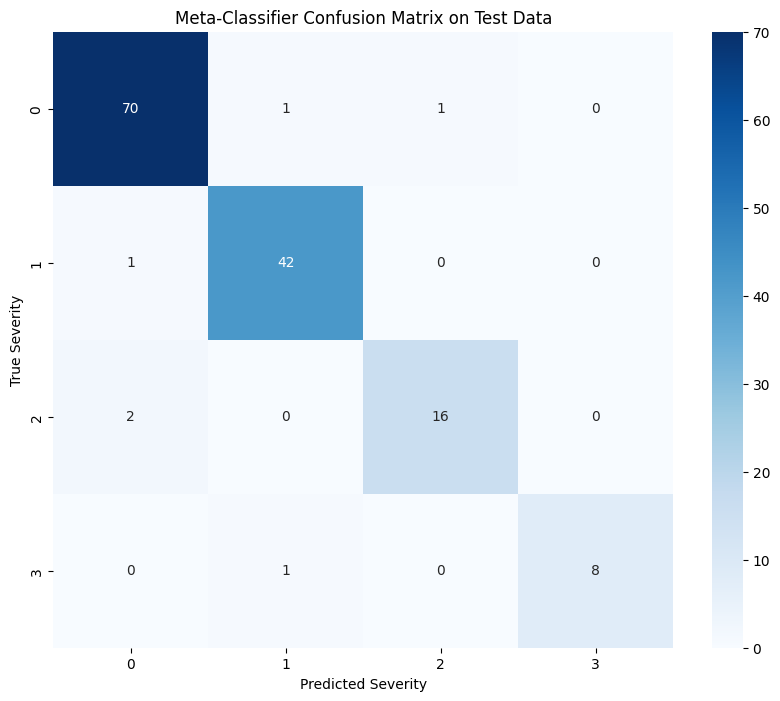

In [54]:
predictions = predict_final(meta_model=train_results['meta_model'])

In [55]:
# Analyze predictions by class
# Create a function to analyze per-class metrics
def analyze_by_class(predictions_df, severity_class):
    class_data = predictions_df[predictions_df['true_severity'] == severity_class]
    
    print(f"Analysis for Severity Class {severity_class}:")
    print(f"Total samples: {len(class_data)}")
    
    correct = class_data['true_severity'] == class_data['predicted_severity']
    print(f"Correctly classified: {sum(correct)} ({sum(correct)/len(class_data)*100:.1f}%)")
    
    # Average probability for the true class
    avg_prob = class_data[f'probability_class_{severity_class}'].mean()
    print(f"Average probability for true class: {avg_prob:.4f}")
    
    # For misclassifications, where do they go?
    if sum(~correct) > 0:
        misclassified = class_data[~correct]
        print("Misclassifications:")
        print(misclassified['predicted_severity'].value_counts())
        
    print("\n")

# Analyze each class
for severity_class in predictions['true_severity'].unique():
    analyze_by_class(predictions, severity_class)

Analysis for Severity Class 0:
Total samples: 72
Correctly classified: 70 (97.2%)
Average probability for true class: 0.9552
Misclassifications:
predicted_severity
2    1
1    1
Name: count, dtype: int64


Analysis for Severity Class 1:
Total samples: 43
Correctly classified: 42 (97.7%)
Average probability for true class: 0.9595
Misclassifications:
predicted_severity
0    1
Name: count, dtype: int64


Analysis for Severity Class 2:
Total samples: 18
Correctly classified: 16 (88.9%)
Average probability for true class: 0.8760
Misclassifications:
predicted_severity
0    2
Name: count, dtype: int64


Analysis for Severity Class 3:
Total samples: 9
Correctly classified: 8 (88.9%)
Average probability for true class: 0.8762
Misclassifications:
predicted_severity
1    1
Name: count, dtype: int64




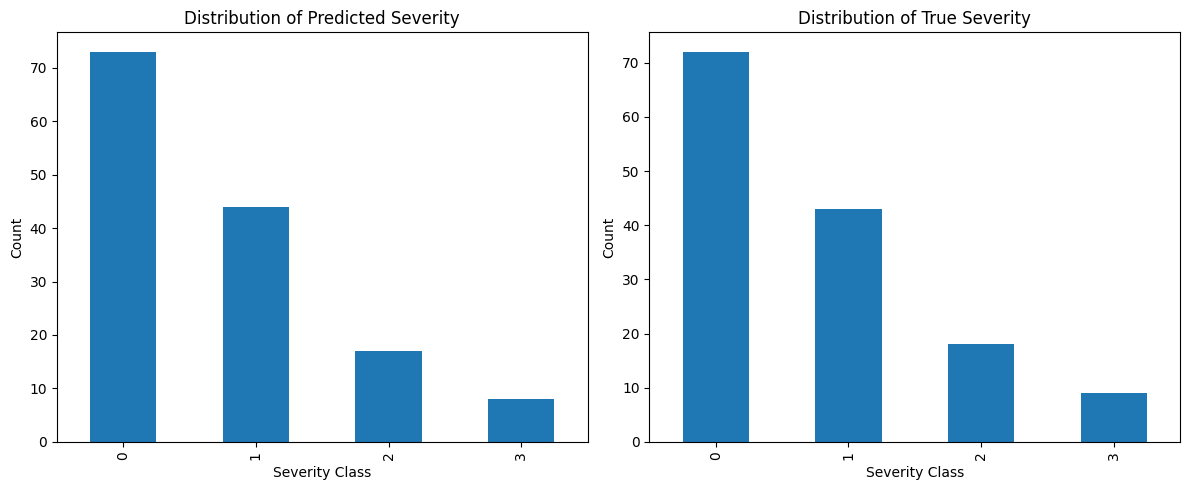

In [56]:

# Analyze prediction distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
predictions['predicted_severity'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Predicted Severity')
plt.xlabel('Severity Class')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
predictions['true_severity'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of True Severity')
plt.xlabel('Severity Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

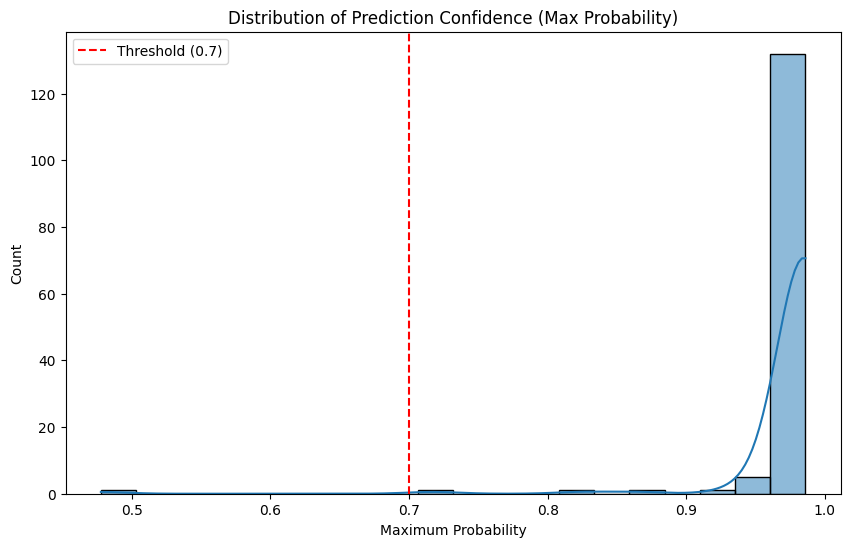

Confident predictions (prob ≥ 0.7): 141 (99.3%)
Uncertain predictions (prob < 0.7): 1 (0.7%)


In [57]:
# Analyze prediction confidence
plt.figure(figsize=(10, 6))
sns.histplot(predictions['max_probability'], bins=20, kde=True)
plt.title('Distribution of Prediction Confidence (Max Probability)')
plt.xlabel('Maximum Probability')
plt.ylabel('Count')
plt.axvline(0.7, color='red', linestyle='--', label='Threshold (0.7)')
plt.legend()
plt.show()

# Count of confident vs uncertain predictions
threshold = 0.7
confident = (predictions['max_probability'] >= threshold).sum()
uncertain = (predictions['max_probability'] < threshold).sum()
print(f"Confident predictions (prob ≥ {threshold}): {confident} ({confident/(confident+uncertain)*100:.1f}%)")
print(f"Uncertain predictions (prob < {threshold}): {uncertain} ({uncertain/(confident+uncertain)*100:.1f}%)")

In [58]:
# Save the trained meta-classifier model
joblib.dump(train_results['meta_model'], 'full_meta_classifier.joblib')
print("Meta-classifier model saved as 'full_meta_classifier.joblib'")

Meta-classifier model saved as 'full_meta_classifier.joblib'
